In [1]:
import pandas as pd
import numpy as np
import copy
import random
from math import sqrt
import scipy.stats as sts

from tqdm import tqdm_notebook

from supplement_package import game
from supplement_package import variables_pecan

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [3]:
from supplement_package.game.gradient import GradientComputation
from supplement_package.game.player import Player
from supplement_package.game.stackelberg import StackelbergPlayer
from supplement_package.game.stackelberg import StackelbergGradientComputation

In [4]:
from supplement_package.variables_pecan.variables import VariablesStorage
from supplement_package.variables_pecan.variables import VariablesGenerator

## Data preliminaries 

In [5]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

In [6]:
community_size = len(dataframe_dict)

D_min = [0 for i in range(community_size)]
D_max = [dataframe_dict[i].demand.max() for i in dataframe_dict.keys()]

G_min = [0 for i in range(community_size)]
G_max = [dataframe_dict[i].grid.max() for i in dataframe_dict.keys()]

Kappa = [[10 if i!=j else 0 for i in range(community_size)] for j in range(community_size)]
#Kappa = [[0 for i in range(community_size)] for i in range(community_size)]

Cost = [[1 for i in range(community_size)] for j in range(community_size)]

probabilities = np.array([0.333, 0.333, 0.333])
#probabilities = np.array([0.25 for i in range(4)])

#Building connections between the nodes

connection_matrix = [[np.random.choice([0,1], p = [0.7,0.3]) for i in range(community_size)] for i in range(community_size)]

for i in range(community_size):
    for j in range(community_size):
        connection_matrix[j][i] = connection_matrix[i][j] if i!=j else 0


Gamma = np.array([0.33, 0.33, 0.33])


len_probas = len(probabilities)


In [7]:
def generate_new_params(sample_size):
    res = {}

    for sample in range(sample_size):
        A_tilde = [random.uniform(0,1) for i in range(community_size)]
        B_tilde = [random.uniform(0,1) for i in range(community_size)]

        a = [random.uniform(0,1) for i in range(community_size)]
        b = [random.uniform(0,1) for i in range(community_size)]
        d = [random.uniform(0,1) for i in range(community_size)]

        #d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
        #g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

        #g_res = np.array(g_res)
        #d_target = np.array(d_target)

        risk_aversion = [random.uniform(0,1) for i in range(community_size)]

        res.update({sample : {'A_tilde' : A_tilde,
                        'B_tilde' : B_tilde,
                        'a' : a,
                        'b' : b,
                        'd' : d,
                        'risk_aversion' : risk_aversion}})

    res_reformed = {(i, key) : res[i][key] for i in range(sample_size) for key in res[0].keys()}
    mindx = pd.MultiIndex.from_tuples(res_reformed.keys())
    df = pd.DataFrame(list(res_reformed.values()), index = mindx)
    df.to_csv(f'../data/param_{sample_size}.csv')

In [8]:
#generate_new_params(2000)

In [9]:
def read_df_param(sample_size):
    df_param = pd.read_csv(f'../data/param_{sample_size}.csv')
    df_param.rename({'Unnamed: 0' : 'Sample', 'Unnamed: 1' : 'Parameter'}, axis=1, inplace= True)
    df_param.set_index(['Sample', 'Parameter'], inplace=True)

    return df_param

In [10]:
df_param = read_df_param(2000)

In [11]:
df_param

0         1         2         3         4  \
Sample Parameter                                                         
0      A_tilde        0.717547  0.654177  0.013093  0.877737  0.104077   
       B_tilde        0.321196  0.454466  0.749068  0.460760  0.372843   
       a              0.989779  0.217117  0.606744  0.074443  0.541778   
       b              0.636386  0.172969  0.723784  0.608133  0.861277   
       d              0.484944  0.755008  0.937329  0.727731  0.151528   
...                        ...       ...       ...       ...       ...   
1999   B_tilde        0.500874  0.324205  0.793247  0.369542  0.548601   
       a              0.369826  0.189197  0.529484  0.746706  0.067378   
       b              0.165610  0.284443  0.799789  0.344621  0.655007   
       d              0.160511  0.253647  0.078895  0.003548  0.356696   
       risk_aversion  0.614504  0.366860  0.442343  0.369069  0.814488   

                             5         6         7         8         9  ...  \
Sample Parameter                                                        ...   
0      A_tilde        0.967468  0.406434  0.921869  0.028222  0.039824  ...   
       B_tilde        0.908785  0.912784  0.468212  0.332271  0.937093  ...   
       a              0.210180  0.136613  0.981449  0.533806  0.062125  ...   
       b              0.718491  0.523857  0.305293  0.481276  0.387807  ...   
       d              0.766490  0.175645  0.453242  0.881070  0.982530  ...   
...                        ...       ...       ...       ...       ...  ...   
1999   B_tilde        0.494079  0.507378  0.196287  0.274166  0.830468  ...   
       a              0.192418  0.881850  0.214001  0.480392  0.216424  ...   
       b              0.095538  0.777456  0.664885  0.335663  0.525495  ...   
       d              0.818701  0.748795  0.930096  0.198560  0.502350  ...   
       risk_aversion  0.842747  0.306297  0.392778  0.889301  0.893431  ...   

                            15        16        17        18        19  \
Sample Parameter                                                         
0      A_tilde        0.328909  0.951172  0.267743  0.295853  0.623533   
       B_tilde        0.147292  0.660800  0.544742  0.880750  0.124592   
       a              0.909541  0.129962  0.028962  0.489391  0.102483   
       b              0.920114  0.520913  0.698510  0.752916  0.159282   
       d              0.053421  0.276132  0.421057  0.892414  0.035648   
...                        ...       ...       ...       ...       ...   
1999   B_tilde        0.867202  0.587262  0.821744  0.288427  0.457723   
       a              0.677218  0.049889  0.495318  0.167262  0.208154   
       b              0.020919  0.373464  0.195096  0.755937  0.543812   
       d              0.126103  0.077541  0.000206  0.730584  0.121553   
       risk_aversion  0.294203  0.536948  0.391047  0.552773  0.035062   

                            20        21        22        23        24  
Sample Parameter                                                        
0      A_tilde        0.973707  0.476848  0.666707  0.155502  0.840464  
       B_tilde        0.279776  0.847677  0.795926  0.096711  0.981173  
       a              0.629521  0.306684  0.514739  0.473038  0.015736  
       b              0.253708  0.064357  0.806582  0.741722  0.066194  
       d              0.915235  0.734328  0.505918  0.427903  0.213077  
...                        ...       ...       ...       ...       ...  
1999   B_tilde        0.736485  0.041824  0.863264  0.355207  0.544960  
       a              0.537937  0.372154  0.950846  0.511756  0.879241  
       b              0.701483  0.355683  0.754106  0.844660  0.259825  
       d              0.173995  0.084644  0.547398  0.256455  0.204323  
       risk_aversion  0.060813  0.778704  0.201295  0.385945  0.658455  

[12000 rows x 25 columns]

In [12]:
dataframe_dict[661]

,date,time,air1,bathroom1,car1,clotheswasher1,dishwasher1,disposal1,drye1,furnace1,grid,kitchenapp1,kitchenapp2,microwave1,refrigerator1,solar,demand,difference
0,2018-11-21,15:15:00,0.0,0.004,0.001,0.0,0.001,0.0,0.0,0.235,0.124,0.004,0.199,0.002,0.002,0.276,0.448,-0.048
1,2018-11-21,15:30:00,0.0,0.004,0.001,0.0,0.001,0.0,0.0,0.235,0.251,0.004,0.199,0.002,0.002,0.167,0.448,-0.030
2,2018-11-21,15:45:00,0.0,0.004,0.001,0.0,0.001,0.0,0.0,0.235,0.419,0.004,0.199,0.002,0.002,0.179,0.448,0.150
3,2018-11-21,16:00:00,0.0,0.004,0.007,0.0,0.001,0.0,0.0,0.235,0.833,0.004,0.199,0.002,0.002,0.076,0.454,0.455
4,2018-11-21,16:15:00,0.0,0.004,0.014,0.0,0.001,0.0,0.0,0.235,1.105,0.004,0.199,0.002,0.002,0.064,0.461,0.708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35027,2018-12-31,22:45:00,0.0,0.005,0.002,0.0,0.001,0.0,0.0,0.024,1.497,0.004,0.182,0.006,0.029,-0.014,0.253,1.230
35028,2018-12-31,23:00:00,0.0,0.005,0.002,0.0,0.001,0.0,0.0,0.190,1.747,0.004,0.181,0.006,0.141,-0.014,0.530,1.203
35029,2018-12-31,23:15:00,0.0,0.005,0.002,0.0,0.001,0.0,0.0,0.010,1.440,0.004,0.182,0.006,0.065,-0.013,0.275,1.152
35030,2018-12-31,23:30:00,0.0,0.005,0.002,0.0,0.001,0.0,0.0,0.140,1.345,0.004,0.182,0.006,0.006,-0.012,0.346,0.987


<AxesSubplot:ylabel='Count'>

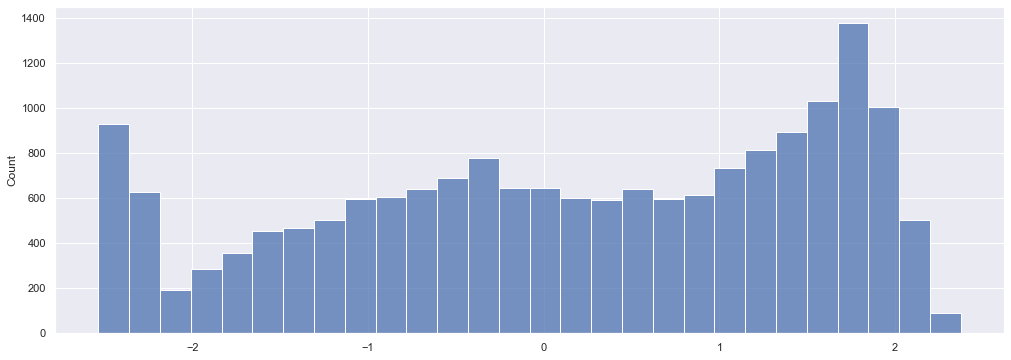

In [13]:
data, n_param = sts.boxcox((dataframe_dict[661][dataframe_dict[661]['solar'] > 0]['solar']))
# Create the plot grid
#fig = plt.figure(figsize=(18,6))
# Histogram
plt.figure(figsize = (17,6))
sns.histplot(data)

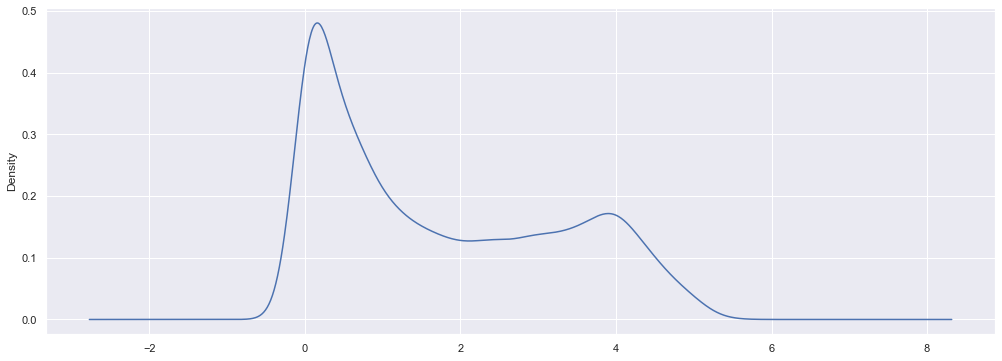

In [14]:
plt.figure(figsize = (17,6))
(dataframe_dict[661][dataframe_dict[661]['solar'] > 0]['solar']).plot.kde();

In [15]:
for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.001) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.999))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

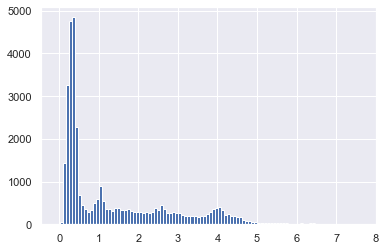

In [16]:
res = plt.hist(dataframe_dict[key]['demand'], bins = 100)

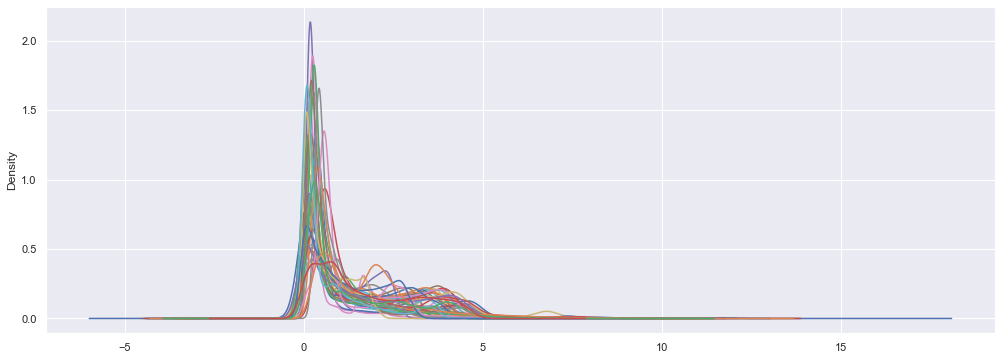

In [17]:
plt.figure(figsize = (17,6))
demand_dict = {}
solar_dict = {}
for key in agent_keys:
    density_demand = dataframe_dict[key]['demand'].plot.kde()

    if 'solar' in dataframe_dict[key].columns and dataframe_dict[key]['solar'].dropna().nunique() > 1:
        density_solar = (dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar']).plot.kde()
        #density_solar = dataframe_dict[key]['solar'].plot.kde()

    density_demand_x = density_demand.get_children()[0]._x
    density_demand_y = density_demand.get_children()[0]._y

    density_solar_x = density_solar.get_children()[0]._x
    density_solar_y = density_solar.get_children()[0]._y

    demand_dict.update({key: (density_demand_x, density_demand_y)})
    solar_dict.update({key :(density_solar_x, density_solar_y)})

In [18]:
def distribution_build(sample_size, agent_keys):
    res = {}
    
    for key in agent_keys:
        #chunks_demand = int(demand_dict[key][0].size / sample_size)
        #chunks_generation = int(solar_dict[key][0].size / sample_size)


        #probas_demand = [np.trapz(demand_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            demand_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_demand)]

        #probas_generation = [np.trapz(generation_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            generation_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_generation)]

        #res_demand = plt.hist(np.random.choice(demand_dict[key][0], size = sample_size, p = probabilities), bins = int(sample_size / 2))
        #probas_update = res_demand[0] / res_demand[0].sum() if key == 661 else res[661]['probabilities']
        #res.update({key : 
        #            {'values' : res_demand[1], 
        #            'probabilities' : probas_update}})

        hist_demand = plt.hist(dataframe_dict[key]['demand'], bins = sample_size)
        probas_demand, values_demand = hist_demand[0], hist_demand[1]
        probas_demand = probas_demand / probas_demand.sum()

        if 'solar' in dataframe_dict[key].columns:
            hist_solar = plt.hist(dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar'], bins = sample_size)
            probas_solar , values_solar  = hist_solar[0], hist_solar[1]
            probas_solar = probas_demand / probas_demand.sum()

        res.update({key : 
                    {'probas_demand' : probas_demand,
                    'values_demand' : values_demand,
                    'probas_solar' : probas_solar,
                    'values_solar' : values_solar}})

    return res 

    


In [19]:
def scenario_sampling(sample_size, agent_keys, main_key = 661):
    distribution = distribution_build(sample_size, agent_keys)

    probabilities = distribution[main_key]['probas_demand']

    d_target = []
    g_res = []
    for key in agent_keys:
        d_target.append(distribution[key]['values_demand'][:-1])
        g_res.append(distribution[key]['values_solar'][:-1])

    return probabilities, d_target, g_res

In [20]:
def param_input(df, index = 0):
    A_tilde = list(df.loc[index].loc['A_tilde'])
    B_tilde = list(df.loc[index].loc['B_tilde'])
    a = list(df.loc[index].loc['a'])
    b = list(df.loc[index].loc['b'])
    d = list(df.loc[index].loc['d'])
    risk_aversion = list(df.loc[index].loc['risk_aversion'])

    return A_tilde, B_tilde, a, b, d, risk_aversion


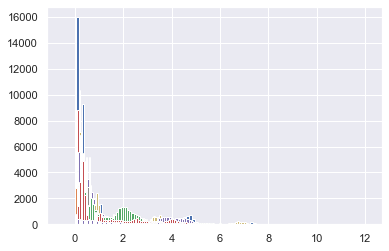

In [21]:
probabilities, d_target, g_res = scenario_sampling(100, agent_keys)
A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param)

In [22]:
def agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion):
    agents = []
    StackelbergPlayer.community_size = community_size
    StackelbergPlayer.probabilities = probabilities

    epsilon = 0.001
    alpha = [[proba/(1 - min(risk_aversion)) - epsilon for proba in probabilities] for i in range(community_size)]
    #alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
    gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

    j_max = [10 for i in range(community_size)]

    for i in range(community_size):
        agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                    A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                    G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                    probabilities = probabilities,
                    alpha = alpha[i], 
                    gamma = gamma, 
                    insurance_bound=j_max[i])
        
        agents.append(agent)

    return agents

In [23]:
def vars_to_dict(model, list_vars):
    var_names = []
    
    for var in model.getVars():
        var_names.append(var.VarName)

    dict_res = {}
    for name, var in zip(var_names, list_vars):
        dict_res.update({name : var})

    return dict_res

In [24]:
def gurobi_experiment(df_param, index, err_track):
    A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, index = index)

    agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion)

    model_1 = gp.Model()
    setup = GurobiSolution(agents=agents,
                    model = model_1,
                    solution_type='centralized')

    model_1.setParam('OutputFlag', 0)

    setup.build_model()

    try:
        model_1.optimize()

        list_vars = model_1.X
        dict_vars = vars_to_dict(model_1, list_vars)
        objective_val = model_1.getObjective().getValue()
        
        
        
    except:
        err_track.append(index)
        list_vars = ['err']
        objective_val = 'err'

    return dict_vars, objective_val

    

## Gurobi

In [25]:
import gurobipy as gp
from supplement_package.gurobi_implementation.gurobi import Gurobi
from supplement_package.gurobi_implementation.gurobi import GurobiSolution
from supplement_package.gurobi_implementation.gurobi import BRGS

In [26]:
agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion)
model_1 = gp.Model()
setup = GurobiSolution(agents=agents,
                model = model_1,
                solution_type='centralized')


setup.build_model()

model_1.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-02
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18000 rows, 27925 columns and 53700 nonzeros
Model fingerprint: 0x1f3cca05
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [8e-03, 1e+00]
  QLMatrix range   [1e-03, 1e+01]
  Objective range  [6e-06, 2e+01]
  Bounds range     [4e+00, 5e+04]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-05, 5e+01]
Presolve removed 7700 rows and 875 columns
Presolve time: 0.02s
Presolved: 25300 rows, 32050 columns, 85325 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.01s

Barrier statistics:
 Dense cols : 25
 Free vars  : 2525
 AA' NZ     : 8.830e+04
 Factor NZ  : 3.417e+05 (roughly 26 MB of memory)
 Factor Ops : 7.439e+06 (less than 1 second per itera

In [27]:
total_results = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective = gurobi_experiment(df_param, index, err_track)
    total_results.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_22124/3832966580.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/2000 [00:00<?, ?it/s]

In [32]:
total_results[0]['vars']

{'D_0_0': 9.317702701738353e-10,
 'D_0_1': 0.031643045718845006,
 'D_0_2': 0.09609497891222607,
 'D_0_3': 0.15990941199162081,
 'D_0_4': 0.22284021566421508,
 'D_0_5': 0.2857689239994759,
 'D_0_6': 0.34869724995404444,
 'D_0_7': 0.41101126379036734,
 'D_0_8': 0.473058252743715,
 'D_0_9': 0.5351048125385277,
 'D_0_10': 0.5971431052421189,
 'D_0_11': 0.6587995227743679,
 'D_0_12': 0.7204174608455678,
 'D_0_13': 0.7820302964023551,
 'D_0_14': 0.8436417348375389,
 'D_0_15': 0.905252445018046,
 'D_0_16': 0.9668632993542751,
 'D_0_17': 1.0284727092809933,
 'D_0_18': 1.0900823840135112,
 'D_0_19': 1.151691311712103,
 'D_0_20': 1.2132976763448309,
 'D_0_21': 1.27484851482341,
 'D_0_22': 1.3363398919576113,
 'D_0_23': 1.3978297406782338,
 'D_0_24': 1.4593169981167944,
 'D_0_25': 1.5208065761019032,
 'D_0_26': 1.582297393844925,
 'D_0_27': 1.6437843206649,
 'D_0_28': 1.7052741392721498,
 'D_0_29': 1.7667675676760586,
 'D_0_30': 1.828235923672309,
 'D_0_31': 1.8897261650576345,
 'D_0_32': 1.95121

In [46]:
pd.DataFrame(data = [list(total_results[0]['vars'].values())], columns=total_results[0]['vars'].keys())

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_90,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99
0,9.317703e-10,0.031643,0.096095,0.159909,0.22284,0.285769,0.348697,0.411011,0.473058,0.535105,...,3.897721e-09,6.482484e-09,4.505046e-09,7.286868e-09,4.503723e-09,7.286298e-09,3.894544e-09,6.481165e-09,9.680052e-09,9.680453e-09


In [50]:
results_vars_pessimistic = pd.DataFrame(data = [list(total_results[0]['vars'].values())],
                                        columns=total_results[0]['vars'].keys())

results_vars_pessimistic['objective'] = total_results[0]['objective']

for i in tqdm_notebook(range(1, len(total_results))):
    df_temp = pd.DataFrame(data = [list(total_results[i]['vars'].values())],
                                        columns=total_results[i]['vars'].keys())
                            
    df_temp['objective'] = total_results[i]['objective']

    results_vars_pessimistic = pd.concat([results_vars_pessimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_22124/2161404130.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results))):


  0%|          | 0/1999 [00:00<?, ?it/s]

In [51]:
results_vars_pessimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,9.317703e-10,3.164305e-02,9.609498e-02,1.599094e-01,2.228402e-01,2.857689e-01,3.486972e-01,0.411011,0.473058,0.535105,...,6.482484e-09,4.505046e-09,7.286868e-09,4.503723e-09,7.286298e-09,3.894544e-09,6.481165e-09,9.680052e-09,9.680453e-09,-10.645517
1,4.472771e-10,8.790332e-10,9.297483e-10,2.376084e-09,5.808008e-09,1.577852e-08,9.824640e-08,0.045950,0.099607,0.151358,...,3.062110e-02,3.562771e-02,2.645987e-01,1.668424e-02,1.874604e-01,2.222832e-04,5.475378e-02,2.350995e+00,2.032907e+00,-24.994929
2,1.688229e-09,4.714816e-09,1.322437e-08,3.175637e-02,9.334010e-02,1.497012e-01,2.060339e-01,0.257469,0.303948,0.352659,...,1.682426e-07,1.554624e-07,1.656065e-07,1.537546e-07,1.664261e-07,1.499254e-07,1.617652e-07,1.922736e-07,1.915195e-07,-7.176180
3,2.407523e-10,3.976742e-10,3.891218e-10,8.322850e-10,1.803004e-09,4.022394e-09,2.503688e-08,0.041795,0.090003,0.136116,...,1.474974e-08,8.798945e-09,1.901767e-08,8.751646e-09,1.862975e-08,6.815242e-09,1.259128e-08,4.788084e-08,3.761452e-08,-8.714323
4,2.661701e-10,3.134480e-02,1.013474e-01,1.667090e-01,2.308726e-01,2.932014e-01,3.552468e-01,0.416944,0.478451,0.539959,...,8.136461e-07,5.203869e-07,1.166476e-06,5.257848e-07,1.214702e-06,4.943996e-07,9.599974e-07,3.693552e-06,4.011785e-06,-5.525343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,6.763012e-10,4.017680e-09,1.306934e-02,6.659821e-02,1.183336e-01,1.700866e-01,2.218943e-01,0.273611,0.323952,0.373004,...,1.538416e-09,1.067165e-09,1.729611e-09,1.067137e-09,1.729530e-09,9.248552e-10,1.539455e-09,2.315935e-09,2.316380e-09,-19.048915
1996,2.453312e-09,4.455819e-08,5.576757e-02,1.172684e-01,1.756824e-01,2.341085e-01,2.925393e-01,0.350977,0.409024,0.467115,...,7.699108e-07,5.828606e-07,9.351452e-07,5.533362e-07,9.079907e-07,4.754197e-07,7.231738e-07,1.266997e-06,1.260588e-06,-20.650302
1997,3.553419e-10,1.923765e-09,1.597589e-08,5.220311e-02,1.081206e-01,1.593192e-01,2.104151e-01,0.260931,0.308216,0.355500,...,1.842265e-07,1.340319e-07,2.206094e-07,1.337117e-07,2.221003e-07,1.373470e-07,1.665734e-07,6.531720e-07,6.418733e-07,-8.002132
1998,3.073384e-10,2.398279e-02,9.270732e-02,1.540623e-01,2.148608e-01,2.754070e-01,3.353011e-01,0.394508,0.452830,0.511076,...,6.873609e-08,5.121279e-08,7.641418e-08,5.112710e-08,7.624388e-08,4.436829e-08,6.863544e-08,1.240044e-07,1.961944e-07,-22.620418


In [52]:
results_vars_pessimistic.to_csv(f'../data/pessimistic_results_{len(results_vars_pessimistic)}.csv')

In [2]:
import pandas as pd

In [3]:
results_vars_pessimistic = pd.read_csv('../data/pessimistic_results_2000.csv')

In [7]:
correlation = results_vars_pessimistic.corrwith(results_vars_pessimistic['objective'])

In [11]:
correlation = correlation.drop('objective')

KeyError: "['objective'] not found in axis"

In [14]:
correlation.idxmax()

'eta_21'

In [35]:
def text_to_adj_matrix(matrix_path):
    res = []
    with open(matrix_path) as file:
        for s in file:
            string = ''.join(s.strip().strip(',').split(', '))
            lst_temp = [int(sym) for sym in string]

            res.append(lst_temp)

    return res



In [48]:
text_to_adj_matrix('../matrices/matrix_4.txt')

[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,